In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In pip, the `-q` or `--quiet` option means to run the installation command without any output, except for error messages. This is useful when you want to suppress the installation details and only view the final output.

In [1]:
!conda --version
!which conda

conda 23.1.0
/usr/local/bin/conda


In [2]:
!conda install -c conda-forge nest-simulator >/dev/null

In the above chunk, `>/dev/null` redirects the standard output of a command to `/dev/null`, which is a special file in Unix-like systems that discards all the data written to it. Then, there is no output, like using `-q` in "pip install" (but using `-q` or `--quiet` in "conda install" still leads to (part of) output -- a little confusing). 

If we also use `2>&1`, which redirects the standard error of the command to the same location as the standard output, then together, `>/dev/null 2>&1` redirects both standard output and standard error to `/dev/null`, which effectively suppresses all output from the command. 

So, `>/dev/null` only redirects the standard output of the command to `/dev/null`, leaving the standard error untouched. Any error messages generated by the command will still be displayed on the screen. We use `>/dev/null` here.

There is another flag `-y`, which is a common command-line option used in package managers like apt-get and yum. It is used to automatically answer "yes" to any prompts that may come up during installation or upgrading of packages, avoiding the need for user input. But it is not needed here, becuase no questions in the installation.

In [12]:
# Loading the necessary modules:
import numpy as np
import matplotlib.pyplot as plt
import nest

## Mesoscopic model

In [13]:
# simulation time interval and record time interval
dt = 0.5
dt_rec = 1.

# simulation time
t_end = 2000.

# populations and their neuron numbers
N = np.array([800, 200])
M = len(N) # numbers of populations

# neuronal parameters
t_ref = 4. * np.ones(M)  # absolute refractory period
tau_m = 20 * np.ones(M)  # membrane time constant
V_rest = 0 # resting potential
mu = 24. * np.ones(M) + V_rest    # constant base current mu=R*I0+Vrest
V_reset = 0. * np.ones(M)    # Reset potential
V_th = 15. * np.ones(M)  # baseline threshold (non-accumulating part)

# exponential link function for the conditional intensity (also called hazard rate, escape rate or conditional rate)
c = 10. * np.ones(M)     # base rate of exponential link function
Delta_u = 2.5 * np.ones(M)   # softness of exponential link function

# threshold adaptation
tau_sfa_exc = [100., 1000.]  # threshold adaptation time constants of excitatory neurons
tau_sfa_inh = [100., 1000.]  # threshold adaptation time constants of inhibitory neurons
J_sfa_exc = [1000., 1000.]   # adaptation strength: size of feedback kernel theta (= area under exponential) in mV*ms
J_sfa_inh = [1000., 1000.]   # in mV*ms
tau_theta = np.array([tau_sfa_exc, tau_sfa_inh])
J_theta = np.array([J_sfa_exc, J_sfa_inh])

# connectivity
J = 0.3  # excitatory synaptic weight in mV if number of input connections is C0 (see below)
g = 5.   # inhibition-to-excitation ratio, -g*J is the weight for inhibitory signals
pconn = 0.2 * np.ones((M, M)) # probability of connections
delay = 1. * np.ones((M, M)) # every two populations have a delay constant
C0 = np.array([[800, 200], [800, 200]]) * 0.2  # constant reference matrix for connections
C = np.vstack((N, N)) * pconn  # numbers of input connections
J_syn = np.array([[J, -g * J], [J, -g * J]]) * C0 / C # final synaptic weights scaling as 1/C

# step current input
step = [[20.], [20.]]  # jump size of mu in mV
tstep = np.array([[1500.], [1500.]])  # times of jumps

# synaptic time constants of excitatory and inhibitory connections
# for calculating post-synaptic currents caused by each spike of presynaptic neurons
tau_ex = 3.  # in ms,
tau_in = 6.  # in ms

In [14]:
nest.set_verbosity("M_WARNING")
nest.ResetKernel()
nest.resolution = dt
nest.print_time = True
nest.local_num_threads = 1

t0 = nest.biological_time

nest_pops = nest.Create('gif_pop_psc_exp', M)

C_m = 250.  # irrelevant value for membrane capacity, cancels out in simulation
g_L = C_m / tau_m

params = [{
    'C_m': C_m,
    'I_e': mu[i] * g_L[i],
    'lambda_0': c[i],  # in Hz!
    'Delta_V': Delta_u[i],
    'tau_m': tau_m[i],
    'tau_sfa': tau_theta[i],
    'q_sfa': J_theta[i] / tau_theta[i],  # [J_theta]= mV*ms -> [q_sfa]=mV
    'V_T_star': V_th[i],
    'V_reset': V_reset[i],
    'len_kernel': -1,  # -1 triggers automatic history size
    'N': N[i],
    't_ref': t_ref[i],
    'tau_syn_ex': max([tau_ex, dt]),
    'tau_syn_in': max([tau_in, dt]),
    'E_L': 0.
} for i in range(M)]
nest_pops.set(params)

# connect the populations
g_syn = np.ones_like(J_syn)  # synaptic conductance
g_syn[:, 0] = C_m / tau_ex
g_syn[:, 1] = C_m / tau_in
for i in range(M):
    for j in range(M):
        nest.Connect(nest_pops[j], nest_pops[i],
                     syn_spec={'weight': J_syn[i, j] * g_syn[i, j] * pconn[i, j],
                               'delay': delay[i, j]})

# monitor the output using a multimeter, this only records with dt_rec!
nest_mm = nest.Create('multimeter')
nest_mm.set(record_from=['n_events', 'mean'], interval=dt_rec)
nest.Connect(nest_mm, nest_pops)

# monitor the output using a spike recorder
nest_sr = []
for i in range(M):
    nest_sr.append(nest.Create('spike_recorder'))
    nest_sr[i].time_in_steps = True
    nest.Connect(nest_pops[i], nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

# set initial value (at t0+dt) of step current generator to zero
tstep = np.hstack((dt * np.ones((M, 1)), tstep))
step = np.hstack((np.zeros((M, 1)), step))

# create the step current devices
nest_stepcurrent = nest.Create('step_current_generator', M)
# set the parameters for the step currents
for i in range(M):
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    pop_ = nest_pops[i]
    nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

# begin simulation for output
nest.rng_seed = 1

t = np.arange(0., t_end, dt_rec)
A_N = np.ones((t.size, M)) * np.nan
Abar = np.ones_like(A_N) * np.nan

# simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)
data_mm = nest_mm.events
for i, nest_i in enumerate(nest_pops):
    a_i = data_mm['mean'][data_mm['senders'] == nest_i.global_id]
    a = a_i / N[i] / dt
    min_len = np.min([len(a), len(Abar)])
    Abar[:min_len, i] = a[:min_len]

    data_sr = nest_sr[i].get('events', 'times')
    data_sr = data_sr * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:, i] = A

Text(0.5, 0, 'time [ms]')

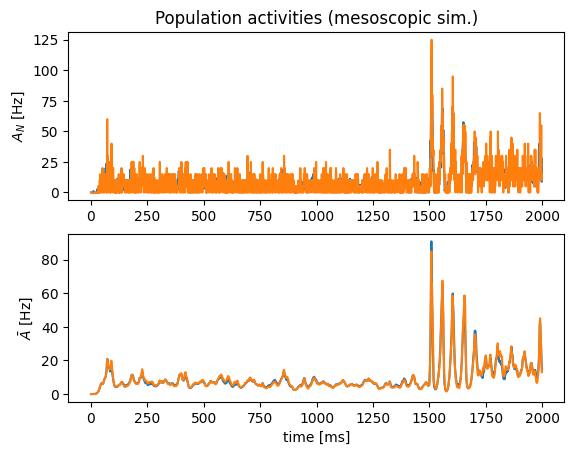

In [18]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, A_N * 1000 * dt_rec)  # plot population activities (in Hz)
plt.ylabel(r'$A_N$ [Hz]')
plt.title('Population activities (mesoscopic sim.)')
plt.subplot(2, 1, 2)
plt.plot(t, Abar * 1000 * dt_rec)  # plot instantaneous population rates (in Hz)
plt.ylabel(r'$\bar A$ [Hz]')
plt.xlabel('time [ms]')

## Microscopic model

In [20]:
nest.ResetKernel()
nest.resolution = dt
nest.print_time = True
nest.local_num_threads = 1

t0 = nest.biological_time

nest_pops = []
for k in range(M):
    nest_pops.append(nest.Create('gif_psc_exp', N[k]))

# set single neuron properties
for i in range(M):
    nest_pops[i].set(C_m=C_m,
                     I_e=mu[i] * g_L[i],
                     lambda_0=c[i],
                     Delta_V=Delta_u[i],
                     g_L=g_L[i],
                     tau_sfa=tau_theta[i],
                     q_sfa=J_theta[i] / tau_theta[i],
                     V_T_star=V_th[i],
                     V_reset=V_reset[i],
                     t_ref=t_ref[i],
                     tau_syn_ex=max([tau_ex, dt]),
                     tau_syn_in=max([tau_in, dt]),
                     E_L=0.,
                     V_m=0.)

# connect the populations
for i, nest_i in enumerate(nest_pops):
    for j, nest_j in enumerate(nest_pops):
        if np.allclose(pconn[i, j], 1.):
            conn_spec = {'rule': 'all_to_all'}
        else:
            conn_spec = {
                'rule': 'fixed_indegree', 'indegree': int(pconn[i, j] * N[j])}

        nest.Connect(nest_j, nest_i,
                     conn_spec,
                     syn_spec={'weight': J_syn[i, j] * g_syn[i, j],
                               'delay': delay[i, j]})

# monitor the output using a multimeter and a spike recorder
nest_sr = []
for i, nest_i in enumerate(nest_pops):
    nest_sr.append(nest.Create('spike_recorder'))
    nest_sr[i].time_in_steps = True

    # record all spikes from population to compute population activity
    nest.Connect(nest_i, nest_sr[i], syn_spec={'weight': 1., 'delay': dt})

Nrecord = [5, 0]    # for each population "i" the first Nrecord[i] neurons are recorded
nest_mm_Vm = []
for i, nest_i in enumerate(nest_pops):
    nest_mm_Vm.append(nest.Create('multimeter'))
    nest_mm_Vm[i].set(record_from=['V_m'], interval=dt_rec)
    if Nrecord[i] != 0:
        nest.Connect(nest_mm_Vm[i], nest_i[:Nrecord[i]], syn_spec={'weight': 1., 'delay': dt})

# create the step current devices if they do not exist already
nest_stepcurrent = nest.Create('step_current_generator', M)
# set the parameters for the step currents
for i in range(M):
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    nest_stepcurrent[i].set(amplitude_times=tstep[i] + t0,
                            amplitude_values=step[i] * g_L[i],
                            origin=t0,
                            stop=t_end)
    # optionally a stopping time may be added by: 'stop': sim_T + t0
    pop_ = nest_pops[i]
    nest.Connect(nest_stepcurrent[i], pop_, syn_spec={'weight': 1., 'delay': dt})

# start the microscopic simulation
nest.rng_seed = 1

t = np.arange(0., t_end, dt_rec)
A_N = np.ones((t.size, M)) * np.nan

# simulate 1 step longer to make sure all t are simulated
nest.Simulate(t_end + dt)

for i in range(len(nest_pops)):
    data_sr = nest_sr[i].get('events', 'times') * dt - t0
    bins = np.concatenate((t, np.array([t[-1] + dt_rec])))
    A = np.histogram(data_sr, bins=bins)[0] / float(N[i]) / dt_rec
    A_N[:, i] = A * 1000  # in Hz

Text(0.5, 1.0, 'Population activities (microscopic sim.)')

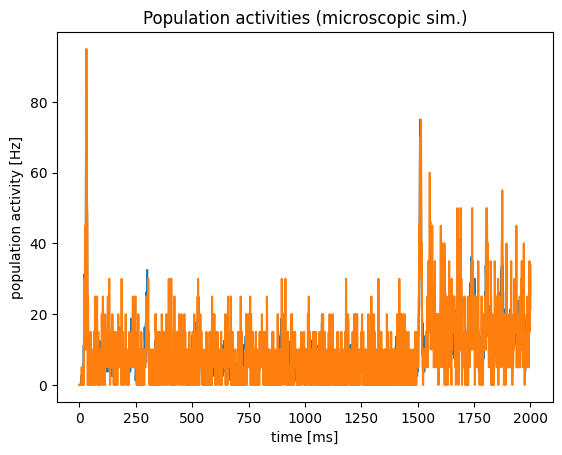

In [25]:
t = np.arange(dt, t_end + dt, dt_rec)

plt.figure()
plt.plot(t, A_N)
plt.xlabel('time [ms]')
plt.ylabel('population activity [Hz]')
plt.title('Population activities (microscopic sim.)')